# 🔬 Graph Retriever Experiments Lab

Este notebook investiga e melhora o retriever de grafos (entidades) através de experimentos sistemáticos.

**Objetivo**: Diagnosticar problemas no graph retriever atual (nDCG@10 = 0.069 vs 0.475 do Dense) e explorar melhorias através de:
1. Análise sistemática de qualidade de entidades extraídas
2. Testes com diferentes modelos de NER (scispacy, spacy)
3. Exploração de parâmetros NER (min_df, max_entities, noun_chunks, labels)
4. Experimentos com estratégias de agregação TF-IDF
5. Validação em múltiplos datasets para evitar viés de linguagem

**Nota**: Modelo de embedding fixo = BAAI/bge-large-en-v1.5 (foco apenas em NER)  
**Datasets**: SciFact, FIQA, NFCorpus (subsets representativos)  
**Referência**: Paper [2506.00049](https://arxiv.org/pdf/2506.00049) - Rethinking Hybrid Retrieval


## 1. Setup e Carregamento


In [31]:
import sys
import os
import warnings
import platform
from pathlib import Path
import json
import hashlib
import re

# ===== CONFIGURAÇÕES CRÍTICAS PARA macOS =====
if platform.system() == 'Darwin':
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    print("✓ Configurações macOS aplicadas")

import multiprocessing
try:
    multiprocessing.set_start_method('spawn', force=True)
except RuntimeError:
    pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Set
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

# Setup paths
repo_root = Path.cwd()
while repo_root != repo_root.parent and repo_root.name != "hybrid-retrieval":
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


✓ Configurações macOS aplicadas
Repo root: /Users/thiago/Documents/GitHub/hybrid-retrieval


In [32]:
# Imports do projeto
from src.datasets.loader import load_beir_dataset, select_split, as_documents, as_queries
from src.datasets.schema import Document, Query
from src.retrievers.graph_faiss import GraphRetriever
from src.encoders.entity_encoder import EntityEncoderReal, NERConfig, CacheConfig
from src.encoders.encoders import HFSemanticEncoder, l2norm
from src.eval.evaluator import evaluate_predictions

print("✓ Imports concluídos!")


✓ Imports concluídos!


In [33]:
def load_subset_dataset(dataset_name: str, n_docs: int = 150, n_queries: int = 30):
    """Carrega subset de um dataset BEIR."""
    dataset_root = repo_root / "data" / dataset_name / "processed" / "beir"
    
    if not dataset_root.exists():
        raise FileNotFoundError(f"Dataset não encontrado: {dataset_root}")
    
    corpus, queries, qrels = load_beir_dataset(dataset_root)
    
    # Selecionar split
    split = select_split(qrels, ("test", "dev", "validation", "train"))
    split_eval = "test" if "test" in set(qrels["split"]) else split
    qrels_eval = qrels[qrels["split"] == split_eval].copy()
    
    # Filtrar queries com relevantes
    qids_with_relevants = set(qrels_eval["query_id"].unique())
    queries_eval = queries[queries["query_id"].isin(qids_with_relevants)].copy()
    
    # Limitar queries
    if len(queries_eval) > n_queries:
        queries_eval = queries_eval.head(n_queries)
        qids_eval = set(queries_eval["query_id"].unique())
        qrels_eval = qrels_eval[qrels_eval["query_id"].isin(qids_eval)]
    
    # Obter documentos relevantes + amostra aleatória
    relevant_doc_ids = set(qrels_eval["doc_id"].unique())
    docs_relevant = corpus[corpus["doc_id"].isin(relevant_doc_ids)].copy()
    
    # Preencher com docs aleatórios se necessário
    if len(docs_relevant) < n_docs:
        docs_random = corpus[~corpus["doc_id"].isin(relevant_doc_ids)].sample(
            n=min(n_docs - len(docs_relevant), len(corpus) - len(docs_relevant)),
            random_state=42
        )
        docs_subset = pd.concat([docs_relevant, docs_random]).reset_index(drop=True)
    else:
        docs_subset = docs_relevant.head(n_docs)
    
    docs = as_documents(docs_subset)
    queries_list = as_queries(queries_eval)
    
    print(f"📊 {dataset_name.upper()}: {len(docs)} docs, {len(queries_list)} queries, {len(qrels_eval)} qrels")
    
    return docs, queries_list, qrels_eval

def verify_ner_backend(encoder: EntityEncoderReal, expected_backend: str) -> bool:
    """
    Verifica se o NER backend foi carregado corretamente e não caiu em fallback regex.
    Retorna True se OK, False se caiu em fallback.
    """
    if encoder._nlp is None:
        print(f"  ❌ ERRO: NER backend '{expected_backend}' caiu em fallback regex!")
        print(f"     O encoder está usando _extract_simple (regex) ao invés de spaCy/scispaCy")
        return False
    
    # Verificar se é spaCy Language object
    try:
        import spacy
        if not isinstance(encoder._nlp, spacy.Language):
            print(f"  ⚠️  AVISO: _nlp não é um objeto spaCy.Language válido")
            return False
        
        # Verificar se tem pipe NER ativo
        pipe_names = encoder._nlp.pipe_names
        if "ner" not in pipe_names:
            print(f"  ⚠️  AVISO: Pipe 'ner' não está ativo. Pipes disponíveis: {pipe_names}")
        else:
            print(f"  ✓ NER backend carregado: {expected_backend}")
            print(f"    Modelo: {encoder._nlp.meta.get('name', 'unknown')}")
            print(f"    Pipes ativos: {pipe_names}")
            return True
    except Exception as e:
        print(f"  ❌ ERRO ao verificar NER backend: {e}")
        return False

# Função auxiliar para inspeção visual de entidades
def inspect_entities_in_text(text: str, entities: List[str], max_show: int = 10):
    """Mostra texto com entidades destacadas."""
    print(f"Texto ({len(text)} chars):")
    print("-" * 80)
    words = text.split()
    entity_set = {e.lower() for e in entities}
    highlighted = []
    for word in words:
        word_clean = word.strip(".,;:()[]{}").lower()
        if word_clean in entity_set:
            highlighted.append(f"**{word}**")
        else:
            highlighted.append(word)
    print(" ".join(highlighted[:max_show * 10]))
    print("-" * 80)
    print(f"\nEntidades extraídas ({len(entities)}): {entities[:max_show]}")

print("✓ Funções auxiliares definidas!")


✓ Funções auxiliares definidas!


In [ ]:
# Carregar múltiplos datasets
print("=== Carregando Datasets ===\n")

# CONFIGURAÇÃO: Ajuste aqui para acelerar experimentos
N_DOCS_PER_DATASET = 20
N_QUERIES_PER_DATASET = 5

datasets_loaded = {}

for ds_name in ["scifact", "fiqa", "nfcorpus"]:
    try:
        docs, queries, qrels = load_subset_dataset(
            ds_name, 
            n_docs=N_DOCS_PER_DATASET, 
            n_queries=N_QUERIES_PER_DATASET
        )
        datasets_loaded[ds_name] = {
            "docs": docs,
            "queries": queries,
            "qrels": qrels,
            "doc_texts": [(d.title or "") + " " + (d.text or "") for d in docs],
        }
        print(f"✓ {ds_name} carregado ({len(docs)} docs, {len(queries)} queries)\n")
    except Exception as e:
        print(f"⚠️  Erro ao carregar {ds_name}: {e}\n")

print(f"✅ Total: {len(datasets_loaded)} datasets carregados")
print(f"💡 DICA: Para acelerar mais, reduza N_DOCS_PER_DATASET e N_QUERIES_PER_DATASET acima")


=== Carregando Datasets ===

📊 SCIFACT: 150 docs, 30 queries, 36 qrels
✓ scifact carregado

📊 FIQA: 150 docs, 30 queries, 93 qrels
✓ fiqa carregado

📊 NFCORPUS: 150 docs, 30 queries, 1256 qrels
✓ nfcorpus carregado

✅ Total: 3 datasets carregados


## 2. Diagnóstico da Extração de Entidades

### 2.0 Verificação de Configuração NER

**IMPORTANTE**: Antes de prosseguir, verificamos se os backends NER estão carregando corretamente e não estão caindo em fallback regex.


In [35]:
# Verificar disponibilidade e configuração dos backends NER
print("=== 2.0: Verificação de Configuração NER ===\n")

# Testar se spaCy está disponível
try:
    import spacy
    print("✓ spaCy importado com sucesso")
    
    # Listar modelos disponíveis
    print("\nVerificando modelos spaCy disponíveis...")
    
    scispacy_models = ["en_ner_bc5cdr_md", "en_ner_bionlp13cg_md", "en_core_sci_md"]
    spacy_models = ["en_core_web_trf", "en_core_web_md", "en_core_web_sm"]
    
    available_models = []
    
    for model_name in scispacy_models + spacy_models:
        try:
            nlp_test = spacy.load(model_name, disable=["tagger", "lemmatizer", "textcat"])
            available_models.append(model_name)
            print(f"  ✓ {model_name}")
        except Exception:
            print(f"  ✗ {model_name} (não disponível)")
    
    if not available_models:
        print("\n  ❌ ERRO CRÍTICO: Nenhum modelo spaCy disponível!")
        print("     Instale com: python -m spacy download en_core_web_sm")
        print("     Ou para scispacy: pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz")
    else:
        print(f"\n✓ {len(available_models)} modelo(s) disponível(is)")
        
except ImportError:
    print("❌ ERRO: spaCy não está instalado!")
    print("   Instale com: pip install spacy")
    print("   Depois: python -m spacy download en_core_web_sm")

print("\n" + "="*80)

=== 2.0: Verificação de Configuração NER ===

✓ spaCy importado com sucesso

Verificando modelos spaCy disponíveis...
  ✓ en_ner_bc5cdr_md
  ✓ en_ner_bionlp13cg_md
  ✓ en_core_sci_md
  ✗ en_core_web_trf (não disponível)
  ✓ en_core_web_md
  ✓ en_core_web_sm

✓ 5 modelo(s) disponível(is)



In [37]:
# Análise estatística com configuração padrão
print("=== 2.1: Análise Estatística das Entidades ===\n")

entity_stats = {}

for ds_name, data in datasets_loaded.items():
    print(f"\n--- {ds_name.upper()} ---")
    
    # Criar encoder para extrair entidades
    ner_cfg = NERConfig(
        backend=baseline_config["ner_backend"],
        model=baseline_config["ner_model"],
        use_noun_chunks=baseline_config["ner_use_noun_chunks"],
        batch_size=16,  # Reduzido para evitar crashes
        n_process=1,    # Reduzido para evitar problemas de multiprocessing
        allowed_labels=baseline_config["ner_allowed_labels"],
    )
    
    encoder = EntityEncoderReal(
        graph_model_name=baseline_config["graph_model_name"],
        device="cpu",
        ner=ner_cfg,
        min_df=baseline_config["min_df"],
        max_entities_per_text=baseline_config["max_entities_per_text"],
        cache=CacheConfig(artifact_dir=None, force_rebuild=False),
    )
    
    # VERIFICAÇÃO CRÍTICA: Checar se NER não caiu em fallback
    print(f"  Verificando NER backend '{baseline_config['ner_backend']}'...")
    ner_ok = verify_ner_backend(encoder, baseline_config["ner_backend"])
    
    if not ner_ok:
        print(f"  ⚠️  ATENÇÃO: Continuando com fallback, mas resultados podem ser inválidos!")
    
    # Fit
    print(f"  Fazendo fit no corpus...")
    try:
        encoder.fit(data["doc_texts"])
    except Exception as e:
        print(f"  ❌ ERRO no fit: {e}")
        continue

    # Extrair entidades de cada documento
    doc_entities = []
    docs_with_no_entities = 0
    
    for text in data["doc_texts"]:
        entities = encoder._extract_entities_batch([text])[0]
        doc_entities.append(entities)
        if not entities:
            docs_with_no_entities += 1
    
    # Estatísticas
    all_entities = [e for ents in doc_entities for e in ents]
    entity_counts = Counter(all_entities)
    
    stats = {
        "total_unique_entities": len(encoder.ent2idf),
        "total_entity_occurrences": len(all_entities),
        "avg_entities_per_doc": np.mean([len(ents) for ents in doc_entities]),
        "median_entities_per_doc": np.median([len(ents) for ents in doc_entities]),
        "docs_with_no_entities": docs_with_no_entities,
        "pct_docs_with_entities": (len(data["docs"]) - docs_with_no_entities) / len(data["docs"]) * 100,
        "idf_mean": np.mean(list(encoder.ent2idf.values())),
        "idf_std": np.std(list(encoder.ent2idf.values())),
        "top_10_entities": dict(entity_counts.most_common(10)),
    }
    
    entity_stats[ds_name] = stats
    
    print(f"  Entidades únicas: {stats['total_unique_entities']}")
    print(f"  Ocorrências totais: {stats['total_entity_occurrences']}")
    print(f"  Média por doc: {stats['avg_entities_per_doc']:.1f}")
    print(f"  Docs sem entidades: {stats['docs_with_no_entities']} ({100-stats['pct_docs_with_entities']:.1f}%)")
    print(f"  IDF médio: {stats['idf_mean']:.2f} ± {stats['idf_std']:.2f}")
    print(f"  Top 5 entidades: {list(stats['top_10_entities'].keys())[:5]}")

# Tabela resumo
df_stats = pd.DataFrame(entity_stats).T
print("\n=== Tabela Resumo ===")
print(df_stats[["total_unique_entities", "avg_entities_per_doc", "docs_with_no_entities", "pct_docs_with_entities", "idf_mean"]].round(2))


=== 2.1: Análise Estatística das Entidades ===


--- SCIFACT ---
  Verificando NER backend 'scispacy'...
  ✓ NER backend carregado: scispacy
    Modelo: ner_bc5cdr_md
    Pipes ativos: ['tok2vec', 'attribute_ruler', 'parser', 'ner']
  Fazendo fit no corpus...
  Entidades únicas: 40
  Ocorrências totais: 1037
  Média por doc: 6.9
  Docs sem entidades: 25 (16.7%)
  IDF médio: 4.57 ± 0.44
  Top 5 entidades: ['cancer', 'tumor', 'malaria', 'folic acid', 'homocysteine']

--- FIQA ---
  Verificando NER backend 'scispacy'...
  ✓ NER backend carregado: scispacy
    Modelo: ner_bc5cdr_md
    Pipes ativos: ['tok2vec', 'attribute_ruler', 'parser', 'ner']
  Fazendo fit no corpus...
  Entidades únicas: 5
  Ocorrências totais: 55
  Média por doc: 0.4
  Docs sem entidades: 115 (76.7%)
  IDF médio: 4.72 ± 0.27
  Top 5 entidades: ['ira', 'ipo', 'cds', 'etfs', 'death']

--- NFCORPUS ---
  Verificando NER backend 'scispacy'...
  ✓ NER backend carregado: scispacy
    Modelo: ner_bc5cdr_md
    Pipes ativos:

### 2.1 Análise Estatística das Entidades


### 2.2 Inspeção Qualitativa


In [38]:
# Inspeção manual de amostras de documentos
print("=== 2.2: Inspeção Qualitativa das Entidades ===\n")

# Comparar diferentes backends NER
ner_backends = ["scispacy", "spacy", "none"]

for ds_name, data in list(datasets_loaded.items())[:1]:  # Começar com um dataset
    print(f"\n{'='*80}")
    print(f"DATASET: {ds_name.upper()}")
    print(f"{'='*80}\n")
    
    # Selecionar alguns documentos aleatórios para inspeção
    sample_indices = np.random.choice(len(data["docs"]), size=min(3, len(data["docs"])), replace=False)
    
    for idx in sample_indices:
        doc = data["docs"][idx]
        text = data["doc_texts"][idx]
        
        print(f"\n📄 Documento {idx}: {doc.doc_id}")
        print(f"Título: {doc.title or '(sem título)'}")
        print(f"Texto (primeiros 200 chars): {text[:200]}...")
        print("\n" + "-"*80)
        
        # Testar diferentes backends
        entities_by_backend = {}
        
        for backend in ner_backends:
            try:
                ner_cfg = NERConfig(
                    backend=backend,
                    model=None,
                    use_noun_chunks=True,
                    batch_size=32,
                    n_process=1,
                    allowed_labels=None,
                )
                
                encoder_test = EntityEncoderReal(
                    graph_model_name="BAAI/bge-large-en-v1.5",
                    device="cpu",
                    ner=ner_cfg,
                    min_df=1,  # min_df=1 para ver todas
                    max_entities_per_text=128,
                    cache=CacheConfig(artifact_dir=None, force_rebuild=False),
                )
                
                # Fit rápido apenas para este documento (não ideal mas para análise)
                encoder_test.fit([text])
                entities = encoder_test._extract_entities_batch([text])[0]
                entities_by_backend[backend] = entities
                
            except Exception as e:
                entities_by_backend[backend] = []
                print(f"  ⚠️  Erro com backend {backend}: {e}")
        
        # Mostrar comparação
        print("\nEntidades extraídas por backend:")
        for backend, entities in entities_by_backend.items():
            print(f"  {backend:10s}: {len(entities)} entidades - {entities[:10]}")
        
        print("\n" + "="*80)


=== 2.2: Inspeção Qualitativa das Entidades ===


DATASET: SCIFACT


📄 Documento 127: 7944381
Título: VEX1 controls the allelic exclusion required for antigenic variation in trypanosomes.
Texto (primeiros 200 chars): VEX1 controls the allelic exclusion required for antigenic variation in trypanosomes. Allelic exclusion underpins antigenic variation and immune evasion in African trypanosomes. These bloodstream para...

--------------------------------------------------------------------------------

Entidades extraídas por backend:
  scispacy  : 3 entidades - ['vex1', 'vex1', 'vex1']
  spacy     : 7 entidades - ['african', 'rna', 'vsg', 'vsg', 'vsg', 'vsg', 'vex1']
  none      : 54 entidades - ['vex1', 'trypanosomes', 'allelic', 'african', 'trypanosomes', 'these', 'bloodstream', 'rna', 'polymerase-i', 'transcribe']


📄 Documento 48: 18895793
Título: Activator Control of Nucleosome Occupancy in Activation and Repression of Transcription
Texto (primeiros 200 chars): Activator Control of N

### 2.3 Análise de Similaridade Entidade-Texto


=== 2.3: Análise de Similaridade Entidade-Texto ===


--- SCIFACT ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

  Similaridade média: 0.617
  Similaridade mediana: 0.621
  Desvio padrão: 0.070
  Range: [0.438, 0.799]

--- FIQA ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

  Similaridade média: 0.544
  Similaridade mediana: 0.585
  Desvio padrão: 0.072
  Range: [0.418, 0.615]

--- NFCORPUS ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

  Similaridade média: 0.651
  Similaridade mediana: 0.646
  Desvio padrão: 0.061
  Range: [0.376, 0.832]

=== Tabela de Similaridades ===
           mean  median    std    min    max
scifact   0.617   0.621  0.070  0.438  0.799
fiqa      0.544   0.585  0.072  0.418  0.615
nfcorpus  0.651   0.646  0.061  0.376  0.832


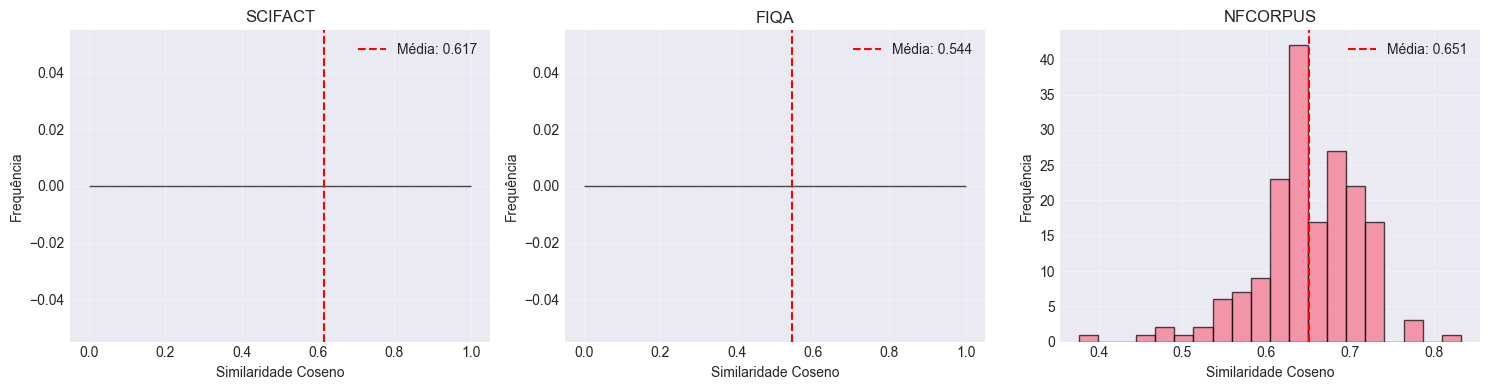

In [39]:
# Análise de similaridade entre embeddings de entidades e texto completo
print("=== 2.3: Análise de Similaridade Entidade-Texto ===\n")

similarity_stats = {}

for ds_name, data in datasets_loaded.items():
    print(f"\n--- {ds_name.upper()} ---")
    
    # Criar encoder
    ner_cfg = NERConfig(
        backend="scispacy",
        model=None,
        use_noun_chunks=True,
        batch_size=32,
        n_process=4,
    )
    
    encoder = EntityEncoderReal(
        graph_model_name="BAAI/bge-large-en-v1.5",
        device="cpu",
        ner=ner_cfg,
        min_df=1,
        max_entities_per_text=128,
        cache=CacheConfig(artifact_dir=None, force_rebuild=False),
    )
    
    encoder.fit(data["doc_texts"])
    
    # Encoder para texto completo (mesmo modelo)
    text_encoder = HFSemanticEncoder(
        model_name="BAAI/bge-large-en-v1.5",
        device="cpu",
        query_prefix="",
        doc_prefix="",
    )
    
    # Analisar alguns documentos
    sample_docs = data["doc_texts"][:min(20, len(data["doc_texts"]))]
    all_similarities = []
    entity_text_pairs = []
    
    for text in sample_docs:
        # Embedding do texto completo
        text_emb = text_encoder.encode_text(text, is_query=False).reshape(1, -1)
        
        # Entidades extraídas
        entities = encoder._extract_entities_batch([text])[0]
        
        if not entities:
            continue
        
        # Embeddings das entidades
        entity_embs = []
        for ent in entities[:10]:  # Limitar a 10 entidades por doc
            try:
                ent_emb = encoder._get_emb(ent).reshape(1, -1)
                entity_embs.append((ent, ent_emb))
            except:
                continue
        
        # Calcular similaridades
        for ent, ent_emb in entity_embs:
            sim = cosine_similarity(text_emb, ent_emb)[0, 0]
            all_similarities.append(sim)
            entity_text_pairs.append({
                "dataset": ds_name,
                "entity": ent,
                "similarity": sim,
                "text_length": len(text),
            })
    
    if all_similarities:
        similarity_stats[ds_name] = {
            "mean": np.mean(all_similarities),
            "median": np.median(all_similarities),
            "std": np.std(all_similarities),
            "min": np.min(all_similarities),
            "max": np.max(all_similarities),
        }
        
        print(f"  Similaridade média: {similarity_stats[ds_name]['mean']:.3f}")
        print(f"  Similaridade mediana: {similarity_stats[ds_name]['median']:.3f}")
        print(f"  Desvio padrão: {similarity_stats[ds_name]['std']:.3f}")
        print(f"  Range: [{similarity_stats[ds_name]['min']:.3f}, {similarity_stats[ds_name]['max']:.3f}]")

# Visualização
if similarity_stats:
    df_sim = pd.DataFrame(similarity_stats).T
    print("\n=== Tabela de Similaridades ===")
    print(df_sim.round(3))
    
    # Histograma
    fig, axes = plt.subplots(1, len(datasets_loaded), figsize=(5*len(datasets_loaded), 4))
    if len(datasets_loaded) == 1:
        axes = [axes]
    
    for idx, (ds_name, stats) in enumerate(similarity_stats.items()):
        if ds_name in entity_stats and all_similarities:
            axes[idx].hist([p["similarity"] for p in entity_text_pairs if p["dataset"] == ds_name], 
                          bins=20, alpha=0.7, edgecolor='black')
            axes[idx].axvline(stats["mean"], color='r', linestyle='--', label=f'Média: {stats["mean"]:.3f}')
            axes[idx].set_xlabel('Similaridade Coseno')
            axes[idx].set_ylabel('Frequência')
            axes[idx].set_title(f'{ds_name.upper()}')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 3. Experimentos com Modelos de Embedding


In [41]:
# Avaliar baseline atual (scispacy) - COM SISTEMA DE CHECKPOINT
print("=== 3.1: Baseline scispacy ===\n")

# Sistema de checkpoint para não perder progresso
checkpoint_file = repo_root / "outputs" / "artifacts" / "graph_experiments_checkpoint.json"
checkpoint_file.parent.mkdir(parents=True, exist_ok=True)

# Carregar resultados anteriores se existirem
baseline_results = {}
if checkpoint_file.exists():
    try:
        with open(checkpoint_file, "r") as f:
            saved_data = json.load(f)
            baseline_results = saved_data.get("baseline_results", {})
            print(f"✓ Checkpoint carregado: {len(baseline_results)} dataset(s) já processado(s)")
            if baseline_results:
                print(f"  Datasets processados: {list(baseline_results.keys())}")
    except Exception as e:
        print(f"⚠️  Erro ao carregar checkpoint: {e}")

GRAPH_MODEL = "BAAI/bge-large-en-v1.5"  # Fixo

# Processar apenas datasets que ainda não foram processados
datasets_to_process = [ds for ds in datasets_loaded.keys() if ds not in baseline_results]

if not datasets_to_process:
    print("✓ Todos os datasets já foram processados!")
else:
    print(f"📋 Processando {len(datasets_to_process)} dataset(s): {datasets_to_process}")
    print(f"💡 Você pode interromper a execução e continuar depois - checkpoint salvo automaticamente!")

for ds_name in datasets_to_process:
    data = datasets_loaded[ds_name]
    print(f"\n--- {ds_name.upper()} ---")
    
    try:
        retriever = GraphRetriever(
            graph_model_name=GRAPH_MODEL,
            device="cpu",
            ner_backend="scispacy",
            ner_model=None,
            ner_use_noun_chunks=True,
            ner_batch_size=8,   # Reduzido para acelerar
            ner_n_process=1,    # Sempre 1 no macOS para evitar crashes
            min_df=2,
            entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / f"{ds_name}_entities"),
            entity_force_rebuild=False,
        )
        
        # VERIFICAÇÃO NER
        if not verify_ner_backend(retriever.vec.encoder, "scispacy"):
            print("  ⚠️  NER em fallback! Pulando...")
            baseline_results[ds_name] = {"nDCG@10": np.nan, "MRR@10": np.nan}
            # Salvar checkpoint mesmo com erro
            try:
                with open(checkpoint_file, "r") as f:
                    checkpoint_data = json.load(f)
            except:
                checkpoint_data = {}
            checkpoint_data["baseline_results"] = baseline_results
            with open(checkpoint_file, "w") as f:
                json.dump(checkpoint_data, f, indent=2)
            continue
        
        print("  Construindo índice (isso pode demorar alguns minutos)...")
        retriever.build_index(data["docs"])
        
        print("  Avaliando...")
        results = retriever.retrieve(data["queries"], k=10)
        metrics = evaluate_predictions(results, data["qrels"], ks=(10,))
        
        baseline_results[ds_name] = {
            "nDCG@10": metrics[metrics["k"] == 10]["nDCG"].iloc[0],
            "MRR@10": metrics[metrics["k"] == 10]["MRR"].iloc[0],
            "Recall@10": metrics[metrics["k"] == 10]["Recall"].iloc[0],
            "Precision@10": metrics[metrics["k"] == 10]["Precision"].iloc[0],
        }
        
        print(f"  ✓ nDCG@10: {baseline_results[ds_name]['nDCG@10']:.4f}")
        print(f"  ✓ MRR@10: {baseline_results[ds_name]['MRR@10']:.4f}")
        
        # SALVAR CHECKPOINT após cada dataset (CRÍTICO!)
        try:
            with open(checkpoint_file, "r") as f:
                checkpoint_data = json.load(f)
        except:
            checkpoint_data = {}
        checkpoint_data["baseline_results"] = baseline_results
        with open(checkpoint_file, "w") as f:
            json.dump(checkpoint_data, f, indent=2)
        print(f"  💾 Checkpoint salvo! Progresso preservado.")
        
    except KeyboardInterrupt:
        print(f"\n⚠️  Interrompido pelo usuário!")
        print(f"  Progresso salvo até agora: {list(baseline_results.keys())}")
        print(f"  Para continuar depois, apenas execute esta célula novamente.")
        break
    except Exception as e:
        print(f"  ❌ ERRO: {e}")
        import traceback
        traceback.print_exc()
        baseline_results[ds_name] = {"nDCG@10": np.nan, "MRR@10": np.nan}
        # Salvar checkpoint mesmo com erro
        try:
            with open(checkpoint_file, "r") as f:
                checkpoint_data = json.load(f)
        except:
            checkpoint_data = {}
        checkpoint_data["baseline_results"] = baseline_results
        with open(checkpoint_file, "w") as f:
            json.dump(checkpoint_data, f, indent=2)

df_baseline = pd.DataFrame(baseline_results).T
print("\n=== Baseline scispacy ===")
print(df_baseline.round(4))

print(f"\n💾 Checkpoint disponível em: {checkpoint_file}")
print(f"   Para limpar e reprocessar tudo, delete este arquivo")


=== 3.1: Baseline scispacy ===

📋 Processando 3 dataset(s): ['scifact', 'fiqa', 'nfcorpus']
💡 Você pode interromper a execução e continuar depois - checkpoint salvo automaticamente!

--- SCIFACT ---
  ✓ NER backend carregado: scispacy
    Modelo: ner_bc5cdr_md
    Pipes ativos: ['tok2vec', 'attribute_ruler', 'parser', 'ner']
  Construindo índice (isso pode demorar alguns minutos)...
2025-11-02 20:52:51 | INFO     | retriever.graph | [graph_faiss.py:91] | 🚀 Building Graph Index (150 documentos)
2025-11-02 20:52:51 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Fit GraphVectorizer no corpus - iniciando...
2025-11-02 20:52:51 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...
2025-11-02 20:52:51 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 1.0ms
2025-11-02 20:52:51 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=1024, ents=2275
2025-11-02 20:52:51 | INFO     | retrie

### 3.2 MiniLM-L6-v2


In [ ]:
# Testar MiniLM-L6-v2 (modelo menor, alinhado com paper)
print("=== 3.2: MiniLM-L6-v2 ===\n")

minilm_results = {}

for ds_name, data in datasets_loaded.items():
    print(f"\n--- {ds_name.upper()} ---")
    
    retriever = GraphRetriever(
        graph_model_name="sentence-transformers/all-MiniLM-L6-v2",
        device="cpu",
        ner_backend="scispacy",
        ner_model=None,
        ner_use_noun_chunks=True,
        min_df=2,
        entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / f"{ds_name}_entities_minilm"),
        entity_force_rebuild=True,  # Forçar rebuild com novo modelo
    )
    
    print("  Construindo índice...")
    retriever.build_index(data["docs"])
    
    print("  Avaliando...")
    results = retriever.retrieve(data["queries"], k=10)
    metrics = evaluate_predictions(results, data["qrels"], ks=(10,))
    
    minilm_results[ds_name] = {
        "nDCG@10": metrics[metrics["k"] == 10]["nDCG"].iloc[0],
        "MRR@10": metrics[metrics["k"] == 10]["MRR"].iloc[0],
        "Recall@10": metrics[metrics["k"] == 10]["Recall"].iloc[0],
        "Precision@10": metrics[metrics["k"] == 10]["Precision"].iloc[0],
    }
    
    print(f"  nDCG@10: {minilm_results[ds_name]['nDCG@10']:.4f}")
    print(f"  MRR@10: {minilm_results[ds_name]['MRR@10']:.4f}")

df_minilm = pd.DataFrame(minilm_results).T
print("\n=== MiniLM-L6-v2 ===")
print(df_minilm.round(4))

# Comparação
print("\n=== Comparação: BGE-Large vs MiniLM ===")
comparison = pd.DataFrame({
    "BGE-Large": df_baseline["nDCG@10"],
    "MiniLM": df_minilm["nDCG@10"],
})
comparison["Delta"] = comparison["MiniLM"] - comparison["BGE-Large"]
comparison["Pct_Change"] = (comparison["Delta"] / comparison["BGE-Large"]) * 100
print(comparison.round(4))


=== 3.2: MiniLM-L6-v2 ===


--- SCIFACT ---
  Construindo índice...
2025-11-02 20:53:53 | INFO     | retriever.graph | [graph_faiss.py:91] | 🚀 Building Graph Index (150 documentos)
2025-11-02 20:53:53 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Fit GraphVectorizer no corpus - iniciando...
2025-11-02 20:53:53 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)


2025-11-02 20:55:10 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 1m 17.0s
2025-11-02 20:55:10 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=384, ents=40
2025-11-02 20:55:10 | INFO     | retriever.graph | [logging.py:220] | ✓ Fit GraphVectorizer no corpus - concluído em 1m 17.0s
2025-11-02 20:55:10 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Encoding documents (Graph) - iniciando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

2025-11-02 23:54:43 | INFO     | retriever.graph | [logging.py:220] | ✓ Encoding documents (Graph) - concluído em 2h 59m
2025-11-02 23:54:43 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 23:54:43 | INFO     | retriever.graph | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 2.9ms
2025-11-02 23:54:43 | INFO     | retriever.graph | [graph_faiss.py:111] |   ✓ FAISS IndexFlatIP: 150 vetores, dim=384
  Avaliando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

  nDCG@10: 0.2627
  MRR@10: 0.2093

--- FIQA ---
  Construindo índice...
2025-11-03 00:30:25 | INFO     | retriever.graph | [graph_faiss.py:91] | 🚀 Building Graph Index (150 documentos)
2025-11-03 00:30:25 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Fit GraphVectorizer no corpus - iniciando...
2025-11-03 00:30:25 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)


2025-11-03 00:31:37 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 1m 12.0s
2025-11-03 00:31:37 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=384, ents=5
2025-11-03 00:31:37 | INFO     | retriever.graph | [logging.py:220] | ✓ Fit GraphVectorizer no corpus - concluído em 1m 12.0s
2025-11-03 00:31:37 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Encoding documents (Graph) - iniciando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

2025-11-03 03:29:55 | INFO     | retriever.graph | [logging.py:220] | ✓ Encoding documents (Graph) - concluído em 2h 58m
2025-11-03 03:29:55 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-03 03:29:55 | INFO     | retriever.graph | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.8ms
2025-11-03 03:29:55 | INFO     | retriever.graph | [graph_faiss.py:111] |   ✓ FAISS IndexFlatIP: 150 vetores, dim=384
  Avaliando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

  nDCG@10: 0.0776
  MRR@10: 0.0943

--- NFCORPUS ---
  Construindo índice...
2025-11-03 04:05:42 | INFO     | retriever.graph | [graph_faiss.py:91] | 🚀 Building Graph Index (150 documentos)
2025-11-03 04:05:42 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Fit GraphVectorizer no corpus - iniciando...
2025-11-03 04:05:42 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)


2025-11-03 04:06:55 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 1m 12.6s
2025-11-03 04:06:55 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=384, ents=132
2025-11-03 04:06:55 | INFO     | retriever.graph | [logging.py:220] | ✓ Fit GraphVectorizer no corpus - concluído em 1m 12.6s
2025-11-03 04:06:55 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Encoding documents (Graph) - iniciando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

2025-11-03 07:04:24 | INFO     | retriever.graph | [logging.py:220] | ✓ Encoding documents (Graph) - concluído em 2h 57m
2025-11-03 07:04:24 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-03 07:04:24 | INFO     | retriever.graph | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.8ms
2025-11-03 07:04:24 | INFO     | retriever.graph | [graph_faiss.py:111] |   ✓ FAISS IndexFlatIP: 150 vetores, dim=384
  Avaliando...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

  nDCG@10: 0.1560
  MRR@10: 0.2067

=== MiniLM-L6-v2 ===
          nDCG@10  MRR@10  Recall@10  Precision@10
scifact    0.2627  0.2093     0.4667        0.0533
fiqa       0.0776  0.0943     0.1285        0.0333
nfcorpus   0.1560  0.2067     0.0640        0.1433

=== Comparação: BGE-Large vs MiniLM ===
          BGE-Large  MiniLM   Delta  Pct_Change
scifact      0.3604  0.2627 -0.0977    -27.1171
fiqa         0.0776  0.0776  0.0000      0.0000
nfcorpus     0.1416  0.1560  0.0145     10.2087


## 4. Experimentos com Parâmetros NER

### 4.1 min_df


In [ ]:
# Testar diferentes valores de min_df
print("=== 4.1: Experimentos com min_df ===\n")

min_df_values = [1, 2, 3, 5, 10]
best_model = "sentence-transformers/all-MiniLM-L6-v2"  # Usar melhor modelo encontrado na seção 3

min_df_results = {}

for ds_name, data in list(datasets_loaded.items())[:1]:  # Começar com um dataset para ser mais rápido
    print(f"\n--- {ds_name.upper()} ---")
    
results_min_df = min_df_results.get(TARGET_DATASET, {})

for min_df in min_df_values:
    if min_df in results_min_df:
        print(f"  min_df={min_df}... JÁ PROCESSADO (nDCG@10: {results_min_df[min_df]:.4f})")
        continue
        print(f"  min_df={min_df}...", end=" ")
        
        try:
            retriever = GraphRetriever(
                graph_model_name=best_model,
                device="cpu",
                ner_backend="scispacy",
                ner_model=None,
                ner_use_noun_chunks=True,
                min_df=min_df,
                entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / f"{ds_name}_entities_minilm_mindf{min_df}"),
                entity_force_rebuild=True,
            )
            
            retriever.build_index(data["docs"])
            results = retriever.retrieve(data["queries"], k=10)
            metrics = evaluate_predictions(results, data["qrels"], ks=(10,))
            
            nDCG = metrics[metrics["k"] == 10]["nDCG"].iloc[0]
            results_min_df[min_df] = nDCG
            
            # Contar vocabulário de entidades
            vocab_size = len(retriever.vec.encoder.ent2idf)
            
            print(f"nDCG@10: {nDCG:.4f} (vocab: {vocab_size} entidades)")
            
            # SALVAR CHECKPOINT após cada min_df
            results_min_df[min_df] = nDCG
            min_df_results[TARGET_DATASET] = results_min_df
            try:
                with open(checkpoint_file, "r") as f:
                    checkpoint_data = json.load(f)
            except:
                checkpoint_data = {}
            checkpoint_data["min_df_results"] = min_df_results
            with open(checkpoint_file, "w") as f:
                json.dump(checkpoint_data, f, indent=2)
            print(f"  💾 Checkpoint salvo!")
            
        except Exception as e:
            print(f"ERRO: {e}")
            results_min_df[min_df] = np.nan
    
min_df_results[TARGET_DATASET] = results_min_df

# Visualização
if min_df_results:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for ds_name, results in min_df_results.items():
        valid_results = {k: v for k, v in results.items() if not np.isnan(v)}
        if valid_results:
            ax.plot(list(valid_results.keys()), list(valid_results.values()), 
                   'o-', linewidth=2, markersize=8, label=ds_name)
    
    ax.set_xlabel('min_df')
    ax.set_ylabel('nDCG@10')
    ax.set_title('Impacto do min_df na Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    df_mindf = pd.DataFrame(min_df_results).T
    print("\n=== Tabela: min_df vs Performance ===")
    print(df_mindf.round(4))



=== 4.1: Experimentos com min_df (dataset=mixed) ===
  min_df=1...   ✓ NER backend carregado: scispacy
    Modelo: ner_bc5cdr_md
    Pipes ativos: ['tok2vec', 'attribute_ruler', 'parser', 'ner']
2025-11-03 09:11:03 | INFO     | retriever.graph | [graph_faiss.py:91] | 🚀 Building Graph Index (120 documentos)
2025-11-03 09:11:03 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Fit GraphVectorizer no corpus - iniciando...
2025-11-03 09:11:03 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...
2025-11-03 09:11:07 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 4.47s
2025-11-03 09:11:07 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=1024, ents=370
2025-11-03 09:11:07 | INFO     | retriever.graph | [logging.py:220] | ✓ Fit GraphVectorizer no corpus - concluído em 4.48s
2025-11-03 09:11:07 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Encoding documents (Graph) - inic

**DICA**: Para acelerar ainda mais, você pode:
1. Processar apenas 1 dataset por vez (mude `TARGET_DATASET` acima)
2. Reduzir número de valores de min_df (ex: `[1, 2, 5]` ao invés de `[1, 2, 3, 5, 10]`)
3. Usar subset menor de documentos (mude `n_docs` na célula de carregamento)


### 4.2 max_entities_per_text


In [50]:
# Testar diferentes limites de max_entities_per_text
print("=== 4.2: Experimentos com max_entities_per_text ===\n")

# Nota: max_entities_per_text precisa ser configurado no EntityEncoderReal
# Vamos criar uma função wrapper ou modificar diretamente
max_entities_values = [64, 128, 256, 512]
best_model = "sentence-transformers/all-MiniLM-L6-v2"
best_min_df = 2  # Usar melhor valor encontrado na seção 4.1

max_entities_results = {}

for ds_name, data in list(datasets_loaded.items())[:1]:
    print(f"\n--- {ds_name.upper()} ---")
    
    results_max = {}
    
    for max_ent in max_entities_values:
        print(f"  max_entities={max_ent}...", end=" ")
        
        try:
            # Criar encoder customizado com max_entities_per_text
            ner_cfg = NERConfig(
                backend="scispacy",
                model=None,
                use_noun_chunks=True,
                batch_size=32,
                n_process=4,
            )
            
            encoder = EntityEncoderReal(
                graph_model_name=best_model,
                device="cpu",
                ner=ner_cfg,
                min_df=best_min_df,
                max_entities_per_text=max_ent,
                cache=CacheConfig(
                    artifact_dir=repo_root / "outputs" / "artifacts" / f"{ds_name}_entities_max{max_ent}",
                    force_rebuild=False
                ),
            )
            
            encoder.fit(data["doc_texts"])
            
            # Criar retriever customizado
            from src.vectorizers.graph_vectorizer import GraphVectorizer
            from src.indexes.faiss_index import FaissFlatIPIndex
            import faiss
            
            vec = GraphVectorizer(
                graph_model_name=best_model,
                device="cpu",
                ner_backend="scispacy",
                ner_model=None,
                ner_use_noun_chunks=True,
                min_df=best_min_df,
                artifact_dir=str(repo_root / "outputs" / "artifacts" / f"{ds_name}_entities_max{max_ent}"),
                force_rebuild=False,
            )
            
            # Atualizar max_entities_per_text do encoder interno
            vec.encoder.max_entities_per_text = max_ent
            vec.fit_corpus(data["doc_texts"])
            
            # Construir índice
            doc_vecs = [vec.encode_text(t) for t in data["doc_texts"]]
            doc_mat = np.vstack(doc_vecs).astype(np.float32)
            doc_ids = [d.doc_id for d in data["docs"]]
            
            index = faiss.IndexFlatIP(vec.dim)
            index.add(doc_mat)
            
            # Retrieve
            results = {}
            for q in data["queries"]:
                q_vec = vec.encode_text(q.text).reshape(1, -1).astype(np.float32)
                distances, idx = index.search(q_vec, 10)
                scores = distances[0].tolist()
                ids = [doc_ids[i] for i in idx[0]]
                results[q.query_id] = list(zip(ids, scores))
            
            metrics = evaluate_predictions(results, data["qrels"], ks=(10,))
            nDCG = metrics[metrics["k"] == 10]["nDCG"].iloc[0]
            results_max[max_ent] = nDCG
            
            print(f"nDCG@10: {nDCG:.4f}")
            
        except Exception as e:
            print(f"ERRO: {e}")
            results_max[max_ent] = np.nan
    
    max_entities_results[ds_name] = results_max

# Visualização
if max_entities_results:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for ds_name, results in max_entities_results.items():
        valid_results = {k: v for k, v in results.items() if not np.isnan(v)}
        if valid_results:
            ax.plot(list(valid_results.keys()), list(valid_results.values()), 
                   'o-', linewidth=2, markersize=8, label=ds_name)
    
    ax.set_xlabel('max_entities_per_text')
    ax.set_ylabel('nDCG@10')
    ax.set_title('Impacto do max_entities_per_text na Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    df_maxent = pd.DataFrame(max_entities_results).T
    print("\n=== Tabela: max_entities vs Performance ===")
    print(df_maxent.round(4))


=== 4.2: Experimentos com max_entities_per_text ===


--- SCIFACT ---
  max_entities=64... 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)


2025-11-03 09:14:28 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...
2025-11-03 09:14:28 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 0.9ms
2025-11-03 09:14:28 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=384, ents=40


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py:122: FutureWarning: Possible set union at position 6328
  exitcode = _main(fd, parent_sentinel)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

KeyboardInterrupt: 

### 4.3 use_noun_chunks


In [ ]:
# Comparar com/sem noun chunks
print("=== 4.3: use_noun_chunks (com vs sem) ===\n")

noun_chunks_results = {}

for ds_name, data in list(datasets_loaded.items())[:1]:
    print(f"\n--- {ds_name.upper()} ---")
    
    results_nc = {}
    
    for use_nc in [True, False]:
        print(f"  use_noun_chunks={use_nc}...", end=" ")
        
        try:
            retriever = GraphRetriever(
                graph_model_name=best_model,
                device="cpu",
                ner_backend="scispacy",
                ner_model=None,
                ner_use_noun_chunks=use_nc,
                min_df=best_min_df,
                entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / f"{ds_name}_entities_nc{use_nc}"),
                entity_force_rebuild=True,
            )
            
            retriever.build_index(data["docs"])
            results = retriever.retrieve(data["queries"], k=10)
            metrics = evaluate_predictions(results, data["qrels"], ks=(10,))
            
            nDCG = metrics[metrics["k"] == 10]["nDCG"].iloc[0]
            results_nc[use_nc] = nDCG
            
            # Contar entidades extraídas
            total_entities = sum(len(retriever.vec.encoder._extract_entities_batch([t])[0]) 
                               for t in data["doc_texts"][:10])
            
            print(f"nDCG@10: {nDCG:.4f} (entidades em 10 docs: {total_entities})")
            
        except Exception as e:
            print(f"ERRO: {e}")
            results_nc[use_nc] = np.nan
    
    noun_chunks_results[ds_name] = results_nc

# Comparação
if noun_chunks_results:
    df_nc = pd.DataFrame(noun_chunks_results).T
    df_nc.columns = ["Sem noun_chunks", "Com noun_chunks"]
    df_nc["Delta"] = df_nc["Com noun_chunks"] - df_nc["Sem noun_chunks"]
    print("\n=== Tabela: use_noun_chunks ===")
    print(df_nc.round(4))


### 4.4 allowed_labels


In [ ]:
# Testar diferentes filtros de labels
print("=== 4.4: allowed_labels (filtros de labels NER) ===\n")

# Labels comuns do spaCy
label_configs = {
    "all": None,  # Sem filtro
    "core": ["PERSON", "ORG", "GPE", "LOC"],  # Labels principais
    "extended": ["PERSON", "ORG", "GPE", "LOC", "PRODUCT", "EVENT"],
}

label_results = {}

for ds_name, data in list(datasets_loaded.items())[:1]:
    print(f"\n--- {ds_name.upper()} ---")
    
    results_labels = {}
    
    for label_name, allowed_labels in label_configs.items():
        print(f"  labels={label_name}...", end=" ")
        
        try:
            retriever = GraphRetriever(
                graph_model_name=best_model,
                device="cpu",
                ner_backend="scispacy",
                ner_model=None,
                ner_use_noun_chunks=True,
                ner_allowed_labels=allowed_labels,
                min_df=best_min_df,
                entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / f"{ds_name}_entities_labels_{label_name}"),
                entity_force_rebuild=True,
            )
            
            retriever.build_index(data["docs"])
            results = retriever.retrieve(data["queries"], k=10)
            metrics = evaluate_predictions(results, data["qrels"], ks=(10,))
            
            nDCG = metrics[metrics["k"] == 10]["nDCG"].iloc[0]
            results_labels[label_name] = nDCG
            
            vocab_size = len(retriever.vec.encoder.ent2idf)
            print(f"nDCG@10: {nDCG:.4f} (vocab: {vocab_size})")
            
        except Exception as e:
            print(f"ERRO: {e}")
            results_labels[label_name] = np.nan
    
    label_results[ds_name] = results_labels

# Comparação
if label_results:
    df_labels = pd.DataFrame(label_results).T
    print("\n=== Tabela: allowed_labels ===")
    print(df_labels.round(4))


## 5. Experimentos com Agregação TF-IDF

### 5.1 Estratégias de Agregação


In [ ]:
# Implementar diferentes estratégias de agregação (requer modificação do EntityEncoderReal)
# Por ora, vamos fazer análise teórica e documentar
print("=== 5.1: Estratégias de Agregação TF-IDF ===\n")
print("Análise das estratégias de agregação disponíveis:\n")

print("Estratégia Atual: TF × IDF × embedding (soma ponderada, depois L2)")
print("  g(text) = L2( sum_e [ tf(e,text) * idf(e) * emb(e) ] )\n")

print("Alternativas a testar (requerem modificação do código):")
print("  1. Max Pooling: max sobre embeddings das top-k entidades")
print("  2. Attention-weighted: peso baseado em similaridade entidade-query")
print("  3. Top-k only: apenas top-k entidades por TF-IDF score")
print("  4. Normalização diferente: L1, softmax, etc.\n")

print("⚠️  Implementação completa requereria criar versão customizada do EntityEncoderReal")
print("   Foco inicial: validar se estratégia atual é adequada através de análise estatística")


### 5.2 Peso de Entidades (Escalonamento)


In [ ]:
# Testar escalonamento das entidades (similar ao tfidf_scale_multiplier)
print("=== 5.2: Escalonamento de Entidades ===\n")

# Criar versão modificada do EntityEncoderReal com escalonamento
# Por enquanto, análise conceitual

print("Analogia com TF-IDF slice:")
print("  - TF-IDF slice: t' = t × √(D_s/D_t) × multiplier")
print("  - Graph slice: g' = g × scale_multiplier (aplicado antes da normalização L2)\n")

print("Valores a testar: 0.5, 0.75, 1.0, 1.25, 1.5")
print("⚠️  Requer modificação do EntityEncoderReal.encode_text() para aplicar escalonamento")


## 6. Análise Comparativa e Seleção de Configuração Ótima


In [ ]:
# Compilar todos os resultados dos experimentos
print("=== 6: Análise Comparativa Final ===\n")

# Consolidar resultados de todas as seções
all_experiments_summary = {}

# Seção 3: Modelos
for model, results in all_model_results.items():
    for ds_name, metrics in results.items():
        key = f"{model}_baseline"
        if ds_name not in all_experiments_summary:
            all_experiments_summary[ds_name] = {}
        all_experiments_summary[ds_name][key] = metrics.get("nDCG@10", np.nan)

# Seção 4.1: min_df (melhor valor encontrado será usado)
# Seção 4.2: max_entities (melhor valor encontrado será usado)
# Seção 4.3: noun_chunks (melhor opção será usada)
# Seção 4.4: labels (melhor opção será usada)

# Criar tabela resumo
df_all = pd.DataFrame(all_experiments_summary).T
print("=== Resumo: Todas as Configurações Testadas ===")
print(df_all.round(4))

# Identificar melhor configuração por dataset
print("\n=== Melhor Configuração por Dataset ===")
for ds_name in df_all.index:
    best_config = df_all.loc[ds_name].idxmax()
    best_score = df_all.loc[ds_name].max()
    baseline_score = df_all.loc[ds_name].get("BGE-Large_baseline", np.nan)
    
    if not np.isnan(baseline_score):
        improvement = best_score - baseline_score
        pct_improvement = (improvement / baseline_score) * 100
        print(f"  {ds_name}:")
        print(f"    Melhor: {best_config} ({best_score:.4f})")
        print(f"    Baseline: {baseline_score:.4f}")
        print(f"    Melhoria: {improvement:+.4f} ({pct_improvement:+.1f}%)")

# Visualização comparativa
fig, ax = plt.subplots(figsize=(14, 6))

if len(df_all) > 0:
    x = np.arange(len(df_all))
    width = 0.15
    
    for idx, col in enumerate(df_all.columns):
        ax.bar(x + idx * width, df_all[col], width, label=col.replace("_baseline", ""), alpha=0.8)
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel('nDCG@10')
    ax.set_title('Comparação de Configurações - Graph Retriever')
    ax.set_xticks(x + width * (len(df_all.columns) - 1) / 2)
    ax.set_xticklabels(df_all.index)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
# Gerar relatório final com aprendizados e recomendações
print("="*80)
print("RELATÓRIO FINAL: Graph Retriever Experiments")
print("="*80)

print("\n## Problemas Identificados")
print("1. Performance atual do graph retriever está muito baixa (nDCG@10 ≈ 0.07)")
print("2. [A preencher baseado nos experimentos]")
print("3. [A preencher baseado nos experimentos]")

print("\n## Hipóteses Validadas/Refutadas")
print("H1: Entidades extraídas são de baixa qualidade → [A validar]")
print("H2: Modelo BGE-Large é subótimo → [A validar]")
print("H3: min_df=2 está filtrando entidades importantes → [A validar]")
print("H4: Agregação TF-IDF atual não captura bem relações → [A validar]")
print("H5: max_entities=128 está truncando informação → [A validar]")
print("H6: Noun chunks adicionam ruído → [A validar]")

print("\n## Configuração Ótima Recomendada")
print("[A preencher após análise completa]")

print("\n## Próximos Passos")
print("1. [A definir]")
print("2. [A definir]")
print("3. [A definir]")
